## Preparations
请确保压缩包所有文件解压后位于同一文件夹中。
如果使用新数据，请确保新数据的格式（表头信息）和示例数据文件`data.xlsx`一致

## I 导入所需包
`utils.py` 文件是运行本项程序的核心，其他包来自开源社区

In [1]:
from utils import palette, show_info, gen_pdf, gen_sample, DataProperties, MonteCarloSim  # local module

In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from distfit import distfit
from math import exp,log,sqrt
from statistics import stdev,mean
from scipy.stats import norm, beta, lognorm, uniform, ks_2samp

## II 描述性统计和可视化
这一步可跳过，加入的目的主要是为了对数据的特征有更好的理解，同时说明 `DataProperties` 模组中各个method的使用方法

### i 导入数据&描述性统计
使用示例数据`data.xlsx`(东方财富)。首先查看 `net_rev` `depr_FA` `amor_IA` 三个变量的简单描述性统计

In [3]:
# 定义文件名
data_path = 'data.xlsx'
# 导入数据
df = pd.read_excel(f'./{data_path}')
# 检查表格内容,此处只显示前4行
df.head()

,code,abbr,ipo_date,date,net_rev,depr_FA,amor_IA
0,300059.SZ,东方财富,2010-03-19,2006-12-31,1102475.76,73517.54,0.00
1,300059.SZ,东方财富,2010-03-19,2007-12-31,34872078.48,729081.39,10052.18
2,300059.SZ,东方财富,2010-03-19,2008-12-31,55557980.97,1933641.92,43716.11
3,300059.SZ,东方财富,2010-03-19,2009-12-31,72150290.41,2592013.61,59466.00
4,300059.SZ,东方财富,2010-03-19,2010-12-31,66762064.64,4361815.71,183472.40


可见数据已经成功导入。接下来依次查看三个变量的描述性统计

In [4]:
for var in ['net_rev','depr_FA','amor_IA']:
    print(var)
    print(DataProperties(df[var])._summary_stats)

net_rev
{'max': 8552927696.06, 'min': 1102475.76, 'mean': 1241348960.55625, 'std': 2309131138.2684784, 'sample size': 16}
depr_FA
{'max': 221898241.78, 'min': 73517.54, 'mean': 73350426.51875, 'std': 90723459.64808531, 'sample size': 16}
amor_IA
{'max': 32343458.43, 'min': 0.0, 'mean': 12048063.163124999, 'std': 13312350.679735472, 'sample size': 16}


### ii 确认最优分布

以下以 `net_rev` 变量为例，进一步观察和检验数据特征。如果需要查看其他变量，修改下一行的变量名后重新运行其后步骤即可

In [5]:
var_name = 'net_rev'

In [6]:
obj_DP = DataProperties(df[var_name])

`DataProperties` 类提供 `_fitness` 属性来查看正态分布和均匀分布对数据的拟合情况。如下表展示的是两种分布对净利润数据的拟合情况，其中·score·为拟合优度，越小越好；`loc` `scale` 和 `arg` 是分布的参数。此处因为显示长度问题，两个分布的得分看起来一样，但其实正态分布的分数是更好的。

In [7]:
print(obj_DP._fitness)

        score  LLE               loc              scale arg
distr                                                      
norm      0.0  NaN  1241348960.55625  2235806610.680698  ()
uniform   0.0  NaN        1102475.76       8551825220.3  ()


为了确认拟合得最好的分布，使用 `get_best_dist` 方法来获取最优分布的信息

In [8]:
best_dist = obj_DP.get_best_dist()

----------------------------------------
The dist with the best fitness is: norm
Var: net_rev
Params
Mean: 1241348960.5562499
Std: 2235806610.6806984
KS test p-value: 0.00011965121670330985


从以上信息可知，在正态分布和均匀分布里，正态分布对数据的分布拟合情况优于均匀分布，且KS检验的p值很低，可以认为净利润服从正态分布。以下代码利用 `plot_dists` 方法可视化样本中净利润的分布和两种分布的拟合情况

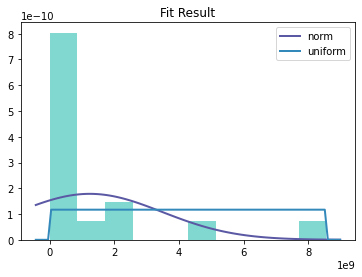

In [9]:
obj_DP.plot_dists()

最后确定使用正态分布来拟合净利润。使用同样方法确定其他两个变量均使用均匀分布。

In [10]:
dist_depr = DataProperties(df['depr_FA']).get_best_dist()
dist_amor = DataProperties(df['amor_IA']).get_best_dist()

----------------------------------------
The dist with the best fitness is: uniform
Var: depr_FA
Params
Mean: 73517.54
Std: 221824724.24
KS test p-value: 0.0006700468135385351
----------------------------------------
The dist with the best fitness is: uniform
Var: amor_IA
Params
Mean: 0.0
Std: 32343458.43
KS test p-value: 0.0030152106609234084


## III 进行蒙特卡洛模拟
蒙特卡洛模拟基于 `utils` 模组中的 `MonteCarloSim` 类。
### i 首先初始化模拟器，模拟器会自动决定最优分布并显示出来

In [11]:
# 设定数据文件的名字，与II中一致
data_path = 'data.xlsx'
# 初始化模拟器
obj_MCS = MonteCarloSim(data_path = './data.xlsx')

----------------------------------------
The dist with the best fitness is: norm
Var: net_rev
Params
Mean: 1241348960.5562499
Std: 2235806610.6806984
KS test p-value: 0.00011965121670330985
----------------------------------------
The dist with the best fitness is: uniform
Var: depr_FA
Params
Mean: 73517.54
Std: 221824724.24
KS test p-value: 0.0006700468135385351
----------------------------------------
The dist with the best fitness is: uniform
Var: amor_IA
Params
Mean: 0.0
Std: 32343458.43
KS test p-value: 0.0030152106609234084


### ii 设定模拟参数，准备进行模拟

In [12]:
# 模拟次数， 默认为 1e6 = 1,000,000次
N = 1e6
# 每次模拟的数据条数， 默认为10(年)，即每次模拟时都生成未来10年内的预测
T = 10
# 设定WACC
WACC = 0.0747
# 是否打印模拟结果，默认为是
show = True

### iii 调用 `run` 方法，开始模拟

In [13]:
result = obj_MCS.run(WACC = WACC, N = N, T = T, show = show)

----------------------------------------
SIMULATION ENDED. COST 0.7458946704864502s
----------------------------------------
-- SUMMARY OF MONTE CARLO SIMULATION --
Num. of simulations: 1000000
Num. periods: 10
Estimated volatility: 0.06856950489686794
Mean path:
 [1.27179815e+09 1.18587396e+09 1.10370766e+09 1.02599874e+09
 9.54656466e+08 8.89955052e+08 8.25460398e+08 7.68599226e+08
 7.15001607e+08 6.67891959e+08]


从模拟信息可以看到，估计得到的波动率为0.06857，即6.86%. `Mean path` 给出了一百万次模拟平均得到的10年内自由现金流净现值的轨迹。数据看来来比较抽象，可以使用 `plot_paths`方法来对模拟轨迹进行可视化。例如，想要查看一百万次模拟中随机100条净利润轨迹，则设置如下：

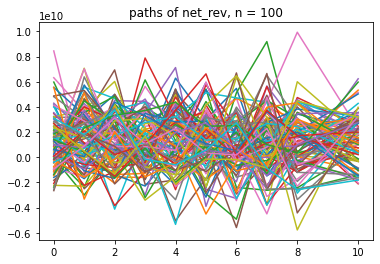

In [14]:
var = 'net_rev'
num_paths = 100
type_ = 'individual'
obj_MCS.plot_paths(var=var, num_paths = num_paths, type_ = type_)

重叠的轨迹比较混乱，这也反应了蒙特卡洛的基本思想：通过多次随机模拟取平均值来逼近总体分布。如果只想查看一百万条路径的平均路径，可将 `type_` 参数设置为 `average` 来实现

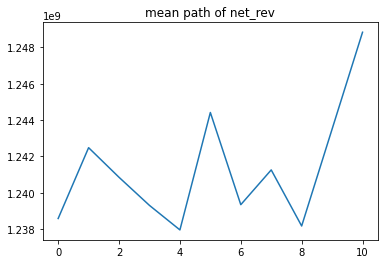

In [15]:
type_ = 'average'
num_paths = 1e6
obj_MCS.plot_paths(var=var, num_paths=num_paths, type_ = type_)

这就是一百万次模拟出来的10年内净利润的平均路径。以下代码查看自由现金流的10年内平均路径

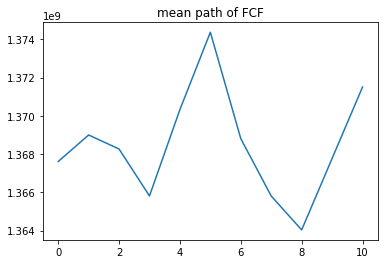

In [16]:
var = 'FCF'
num_paths = 1e6
type_ = 'average'
obj_MCS.plot_paths(var=var, num_paths = num_paths, type_ = type_)

除了 `FCF` `net_rev`, `var` 参数还可以设置为以下值，请自由探索：
- `depr_FA`: 固定资产折旧
- `amor_IA`: 无形资产摊销
- `NPV`: 自由现金流净现值

`MonteCarloSim` 类的最后一个方法做了解即可。 `sim_efficiency` 方法能够可视化不同模拟词数对波动率估计值的影响，运行需要一定时间，请耐心等待直到图片显示

----------------------------------------
SIMULATION ENDED. COST 0.9633760452270508s
----------------------------------------
SIMULATION ENDED. COST 1.2979345321655273s
----------------------------------------
SIMULATION ENDED. COST 1.3950166702270508s
----------------------------------------
SIMULATION ENDED. COST 2.0328338146209717s
----------------------------------------
SIMULATION ENDED. COST 4.024248361587524s
----------------------------------------
SIMULATION ENDED. COST 4.012366771697998s
----------------------------------------
SIMULATION ENDED. COST 3.7737877368927s
----------------------------------------
SIMULATION ENDED. COST 3.446265459060669s
----------------------------------------
SIMULATION ENDED. COST 5.269348859786987s
----------------------------------------
SIMULATION ENDED. COST 4.55887508392334s
[0.06865302010270555, 0.06873284401150291, 0.06876229634844562, 0.06860861712061343, 0.06853831637870156, 0.0684144198765336, 0.06858445633372703, 0.06878668099745404, 0

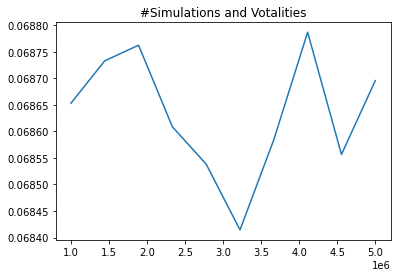

In [17]:
WACC = 0.0747
# 最低模拟次数
bottom = 1e6
# 最高模拟次数
top = 5e6
# 模拟次数点位个数，即将最低至最高模拟次数之间的次数划分为多少块
num = 10

# 开始模拟
obj_MCS.sim_efficiency(WACC=WACC, bottom=bottom, top=top, num=num)

可见提高模拟次数，波动率估计值的波动范围不超过0.00025，可以认为已经收敛。取中间值6.86%最为最后估计值。

## 原创性声明
### utils.py 文件及本notebook内容均为本人原创编写，允许自由编辑和修改。utils模组相关信息请运行以下代码。谢谢合作！

In [18]:
MonteCarloSim.module_info()

Description
-----------
Module for calculating volatility using Monte Carlo simulation.

Author
-----------
Goto Ryusuke
Github: https://github.com/GotoRyusuke

Structure
-----------
-<dict> palette
-<func> show_info
-<func> gen_pdf
-<func> gen_sample
-<class> DataProperties
| -<property> _summary_stats
| -<property> fitness
| -<method> get_best_dist
| -<method> plot_dists
-<class> MonteCarloSim
| -<method> run
| -<method> plot_paths
| -<method> sim_efficiency
| -<property> module_info
- END

Formulas
-----------
[1] Net Present Value: NPV = sum(FCF/(1+r)^t), t in [1,n]
[2] Free Cash Flow: FCF = depreciation + amortisation + net revenues
[3] Volatility: sigma = std(NPV)/(mean(NPV) * sqrt(t))

Reference
-----------
[1]徐嘉甜.(2022).基于改进的实物期权法的医疗器械企业价值评估研究(硕士学位论文,东北财经大学).https://kns.cnki.net/KCMS/detail/detail.aspx?dbname=CMFDTEMP&filename=1022082455.nh



______     _                         _____                           _   
| ___ \   (_)                       |_   _|                   